In [5]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
from astropy.io import fits


import camb
from camb import model, initialpower
import treecorr
from scipy.special import erf


In [2]:
imap = hp.read_map('output/colore_imap_s1_nu000.fits')
med_T=np.average(imap)
DeltaT=imap-med_T
nside = hp.get_nside(imap)
npix = hp.get_map_size(imap)
pixel_indices = np.arange(npix)
theta, phi = hp.pix2ang(nside, pixel_indices)
# phi is longitude (0 to 2π), theta is co-latitude (0 to π)
ra = np.degrees(phi)          # Right ascension in degrees
dec = 90.0 - np.degrees(theta) # Declination in degrees (convert from co-latitude)

intensity_values = imap-med_T

catalog_imap = treecorr.Catalog(ra=ra, dec=dec, k=intensity_values, 
                          ra_units='deg', dec_units='deg')

cat = fits.open("mapas/colore_srcs_s1_0.fits")[1].data
catalog_sources = treecorr.Catalog(ra=cat["RA"], dec=cat["DEC"], 
                          ra_units='deg', dec_units='deg')


nk = treecorr.NKCorrelation(min_sep=1, max_sep=10, nbins=100, sep_units='degrees')
nk.process(catalog_sources, catalog_imap)

xi, varxi = nk.calculateXi()

r = np.exp(nk.meanlogr)

In [ ]:




h0=0.6774
H0=h0*100
Om=0.31
OL=1-Om
Ob=0.05
Ocdm=Om-Ob
As = 2.142e-9
ns = 0.967

def get_pk(z_in):
    """Returns k, Pk, f and sigma8
    in h units"""
    #Set up the fiducial cosmology
    pars = camb.CAMBparams()
    #Set cosmology
    pars.set_cosmology(H0=H0, ombh2=Ob*h0**2, omch2=Ocdm*h0**2,omk=0,mnu=0)
    pars.set_dark_energy() #LCDM (default)
    pars.InitPower.set_params(ns=ns, r=0, As=As)
    pars.set_matter_power(redshifts=[z_in], kmax=2.0)
    pars.NonLinear = model.NonLinear_none
    results = camb.get_results(pars)
    kh, z, pk = results.get_matter_power_spectrum(minkh=1e-4, maxkh=2.0, npoints = 500)
    
    s8 = results.get_sigma8()
    f = results.get_fsigma8()/s8
    
    return kh, pk[0], f[0], s8[0]

def Pk_noh(zc,kk):
    """Returns Pk, its derivative and 
    f and sigma8"""
    kh, pk, f, s8 = get_pk(zc)
    Pkz=splrep(kh*h0, pk[0]/h0**3)
    return splev(kk,Pkz),splev(kk,Pkz,der=1), f, s8

k_h, pk_h, f, s8 = get_pk(0)
from camb.sources import SplinedSourceWindow
csm = {'omega_M': Om,
       'omega_B': Ob,
       'omega_L': OL,
       'h': h0,
       'w': -1.0,
       'ns': ns,
       'sigma_8': s8}
cosmo = ccl.Cosmology(Omega_c=csm['omega_M']-csm['omega_B'],
                      Omega_b=csm['omega_B'],
                      h=csm['h'],
                      sigma8=csm['sigma_8'],
                      n_s=csm['ns'],
                      transfer_function='eisenstein_hu')


def dndz_des_alonso(zi, amp=22.357, alpha=1.044, z0=0.568, beta=1.742):
    """
    in deg⁻2
    """
    return amp*(zi/z0)**alpha*np.exp(-(zi/z0)**beta)*3600/100

zs = np.arange(0.0, 1.5, 0.001)


def W_err(z,zc,sz,smooth):
    return (erf((zc+sz-z)/(np.sqrt(2)*smooth))-erf((zc-sz-z)/(np.sqrt(2)*smooth)))/2

# Get angular power spectrum for galaxy number counts and lensing
pars = camb.CAMBparams()
pars.set_cosmology(H0=H0, ombh2=Ob*h0**2, omch2=Ocdm*h0**2)
pars.InitPower.set_params(As=As, ns=ns)
lmax = 5000
pars.set_for_lmax(lmax, lens_potential_accuracy=1)

Ws=W_err(zs,0.7,0.1,0.01)
nz = dndz_des_alonso(zs)

pars.Want_CMB = False
pars.NonLinear = model.NonLinear_both
pars.SourceWindows = [SplinedSourceWindow(z=zs, W=Ws, bias_z=np.ones(len(zs))), SplinedSourceWindow(z=zs, W=nz, bias_z=np.ones(len(zs)))]

results = camb.get_results(pars)
cls = results.get_source_cls_dict(raw_cl=True)

In [20]:
print(cls.keys())

dict_keys(['PxP', 'PxW1', 'PxW2', 'W1xP', 'W1xW1', 'W1xW2', 'W2xP', 'W2xW1', 'W2xW2'])


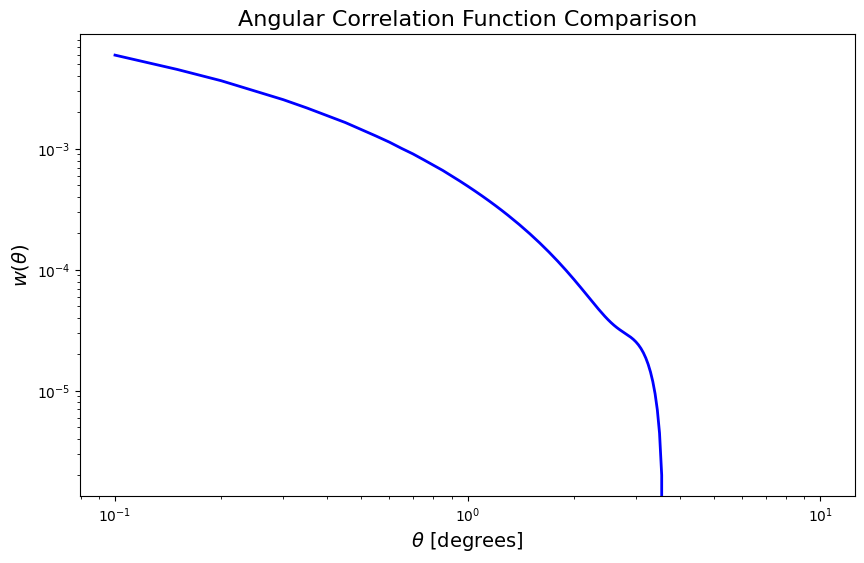

In [21]:
import pyccl as ccl

lmax = 5000

ls = np.arange(2, lmax+1)
ell, C_ell = ls, cls['W1xW2'][2 : lmax + 1]

#theta = np.logspace(-2, 1, 100)  # 0.01 to 10 degrees
theta = np.arange(0.1, 10, 0.05)  # 0.01 to 10 degrees


wtheta = ccl.correlation(cosmo, ell=ell, C_ell=C_ell, 
                         theta=theta, type='NN', method='FFTLog')

plt.figure(figsize=(10, 6))
plt.loglog(theta, wtheta, 'b-', linewidth=2)

plt.xlabel(r'$\theta$ [degrees]', fontsize=14)
plt.ylabel(r'$w(\theta)$', fontsize=14)
plt.title('Angular Correlation Function Comparison', fontsize=16)
plt.show()

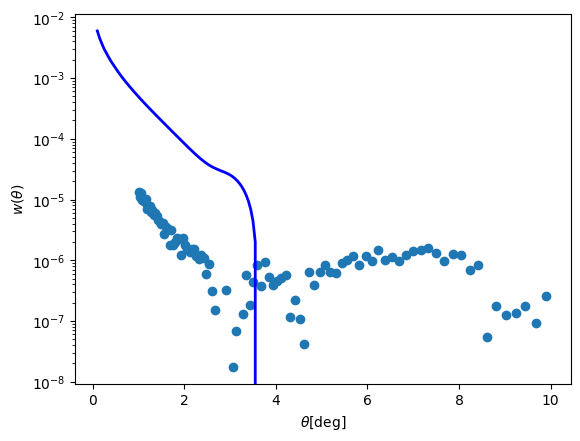

: 

In [ ]:
plt.plot(r, xi,'o',ls='',label='CoLoRe')
plt.plot(theta, wtheta, 'b-', linewidth=2,)
plt.xlabel(r'$\theta [\deg]$')
plt.ylabel(r'$w(\theta)$')
plt.yscale('log')
plt.show()